<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#Регрессия-LGBMRegressor" data-toc-modified-id="Регрессия-LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Регрессия LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Dummy-Regressor" data-toc-modified-id="Dummy-Regressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Dummy Regressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Регрессия-LGBMRegressor" data-toc-modified-id="Регрессия-LGBMRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Регрессия LGBMRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.stattools import adfuller
import os
from sklearn.model_selection import TimeSeriesSplit

from tqdm import tqdm, tqdm_notebook


In [4]:
path1 = 'taxi.csv'
if os.path.exists(path1):
    df = pd.read_csv(path1, index_col=[0], parse_dates=[0])
    df.sort_index(inplace=True)
else:
    print('Something wrong!')

_Спасибо, исправила!_

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df_resample = df.resample('1H').sum()

In [8]:
df_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


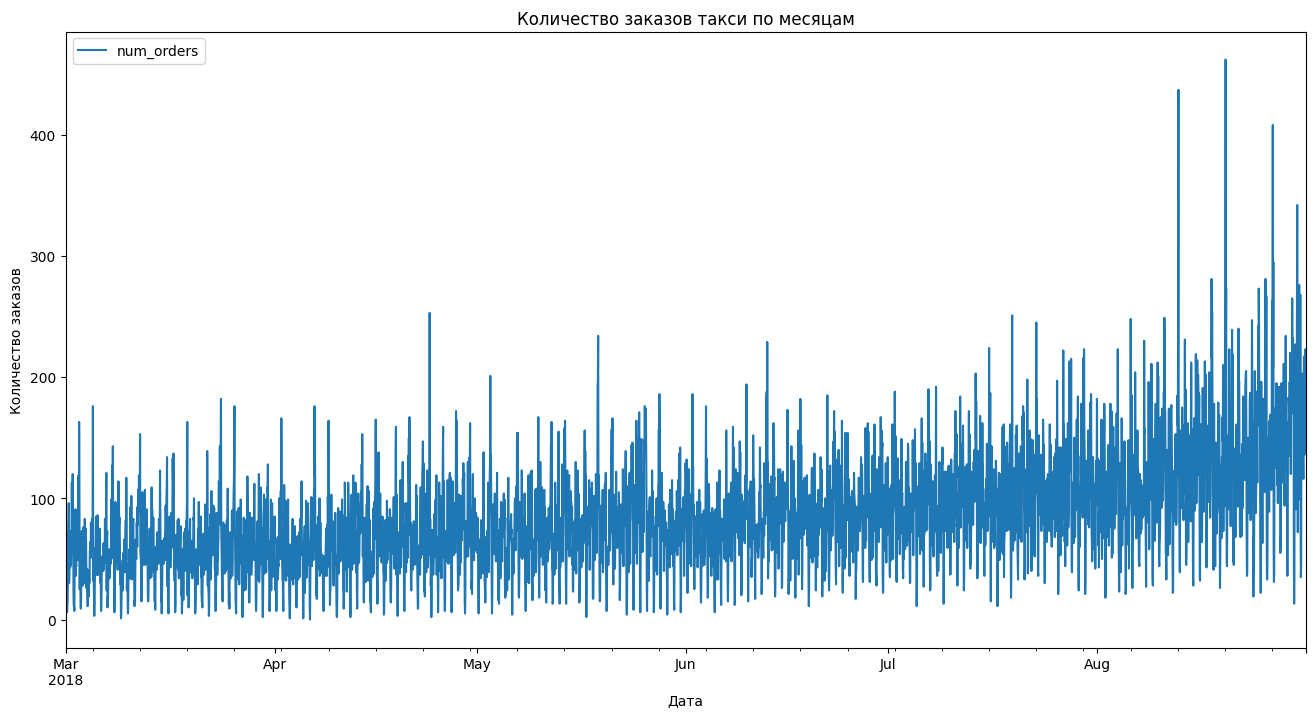

In [9]:
df_resample.plot(figsize=(16,8));
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Количество заказов такси по месяцам')
plt.show()

У нас имеются данные с марта по сентябрь 2018 года. Можем увидеть, что большинство заказов принадлежит интервалу от 0 до 100, с некоторым возрастанием среднего количества заказов в августе-сентябре.

## Анализ

In [12]:
# посмотрим на данные последней недели
df_resample.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [13]:
decomposed_df_resample = seasonal_decompose(df_resample)

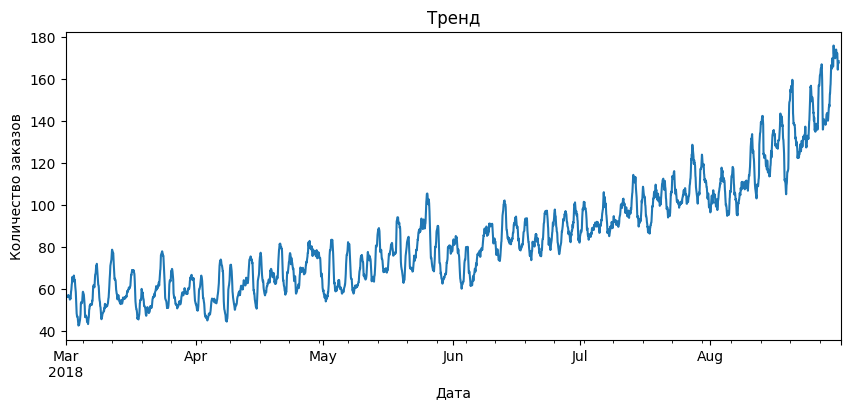

In [14]:
decomposed_df_resample.trend.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Тренд')
plt.show()

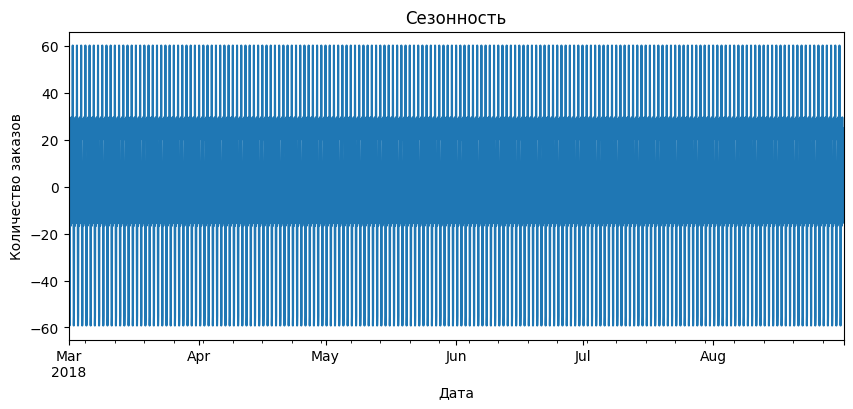

In [15]:
decomposed_df_resample.seasonal.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Сезонность')
plt.show()

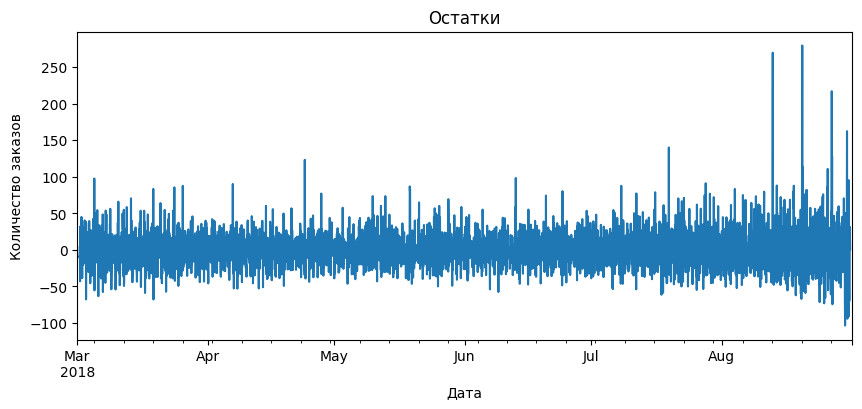

In [16]:
decomposed_df_resample.resid.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Остатки')
plt.show()

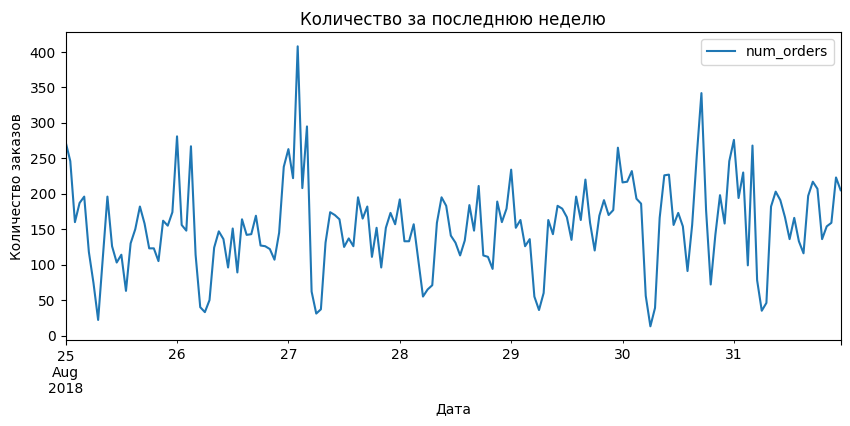

In [17]:
# посмотрим на последенюю неделю
last_week = df_resample['2018-08-25':'2018-08-31']
last_week.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Количество за последнюю неделю')
plt.show()
plt.show()

In [18]:
last_week_decomposed = seasonal_decompose(last_week)

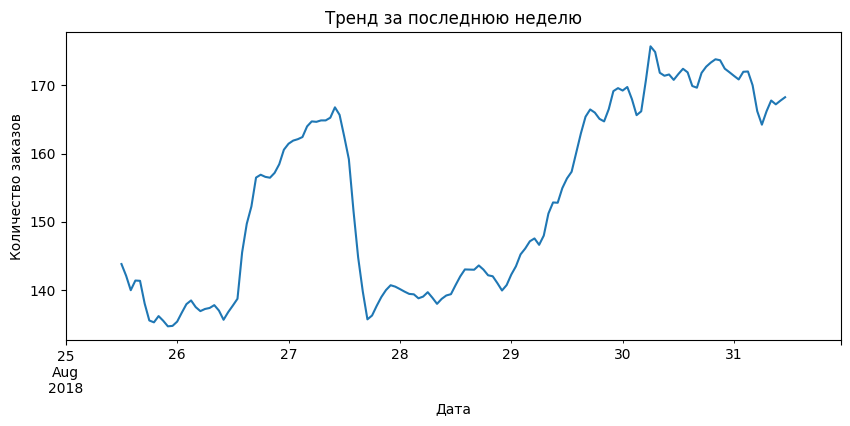

In [19]:
last_week_decomposed.trend.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Тренд за последнюю неделю')
plt.show()

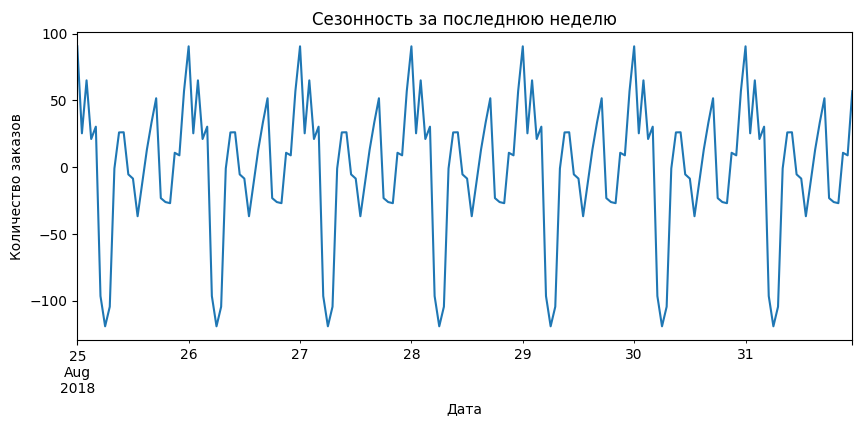

In [20]:
last_week_decomposed.seasonal.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Сезонность за последнюю неделю')
plt.show()

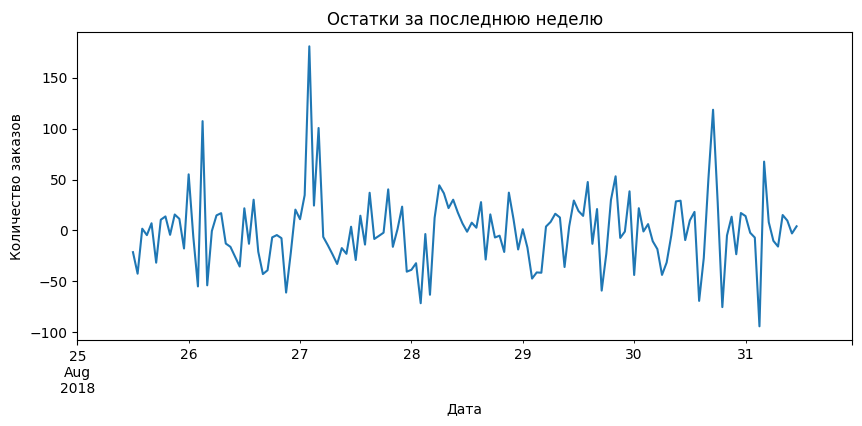

In [21]:
last_week_decomposed.resid.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Остатки за последнюю неделю')
plt.show()

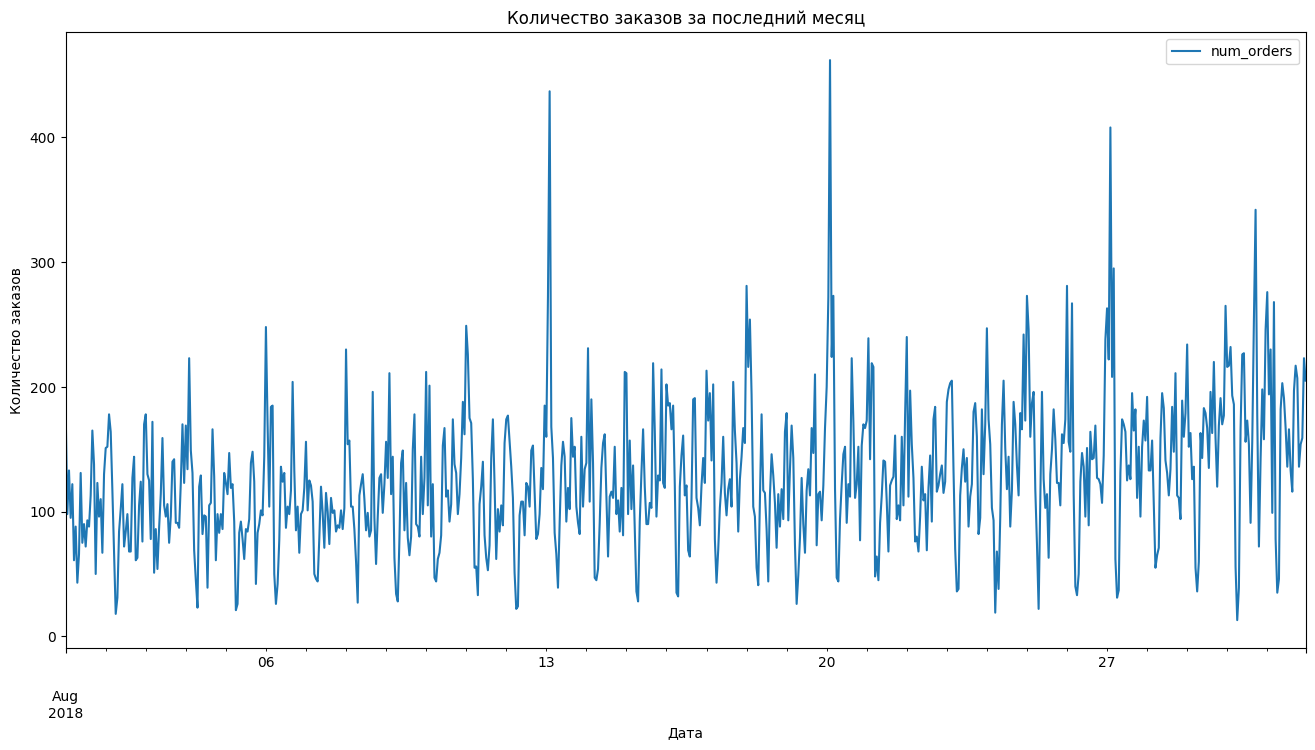

In [22]:
# посмотрим на последений месяц
last_month = df_resample['2018-08-1':'2018-08-31']
last_month.plot(figsize=(16,8))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Количество заказов за последний месяц')
plt.show()

In [23]:
last_month_decomposed = seasonal_decompose(last_month)

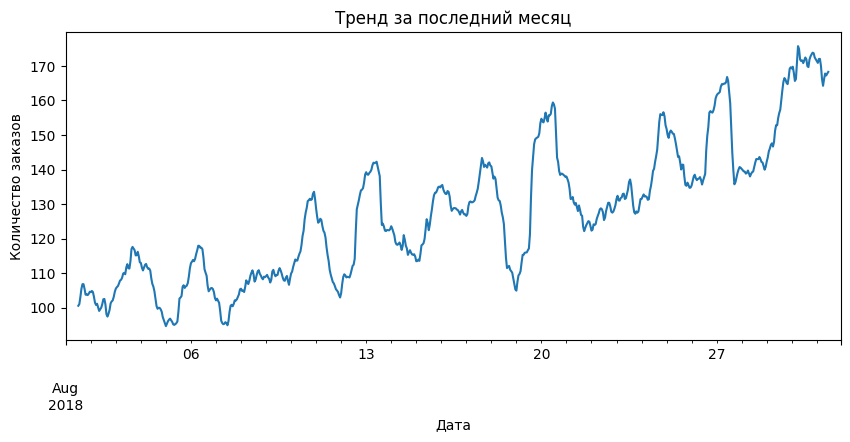

In [24]:
last_month_decomposed.trend.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Тренд за последний месяц')
plt.show()

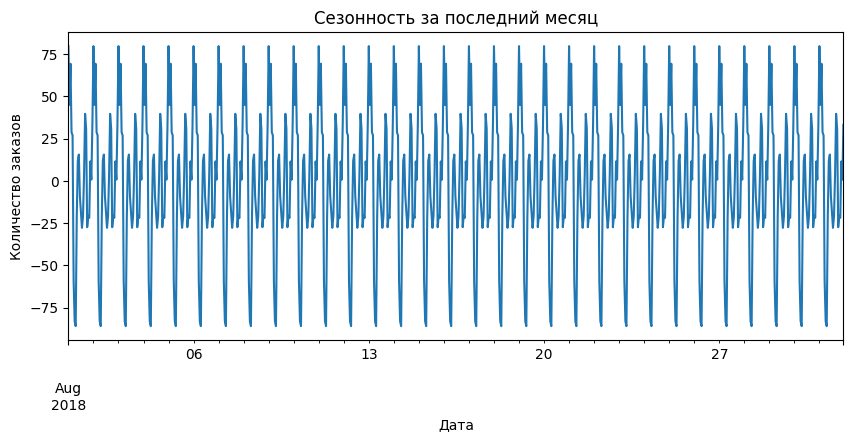

In [25]:
last_month_decomposed.seasonal.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Сезонность за последний месяц')
plt.show()

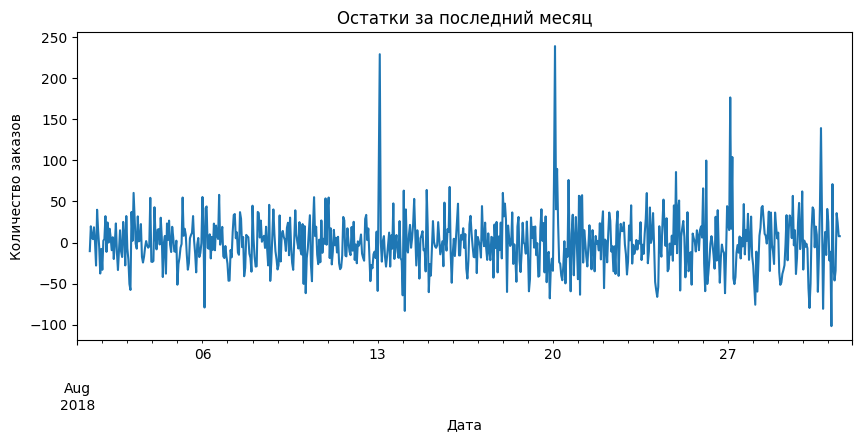

In [26]:
last_month_decomposed.resid.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Остатки за последний месяц')
plt.show()

Из графиков непонятно, является ли ряд стационарным или нет. Нужен статистический критерий для проверки на стационарность. Таким критерием является тест Дики-Фуллера.

Нулевая гипотеза - временной ряд нестационарен
Альтернативная гипотеза - временной ряд стационарен

In [27]:
test = adfuller(df_resample)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if (test[0] > test[4]['5%']):
    print('Ряд не стационарен 5%')
else:
    print('Ряд стационарен 5%')


if (test[0] > test[4]['1%']):
    print('Ряд не стационарен 1%')
else:
    print('Ряд стационарен 1%')

adf:  -3.0689242890279504
p-value:  0.028940051402613316
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Ряд стационарен 5%
Ряд не стационарен 1%


 1. Из анализа трендовой компоненты видно, что количество заказов увеличивается
 2. Природа сезонности суточная. Из графиков за несколько дней видно, что количество заказов такси резко увеличивается в ночное время, а для утреннего времени наблюдается некоторый спад. Скорее всего, это связано с особенностями движения общественного транспорта, который ходит значительно реже в ночное время суток.
 3. Проверка на стационарность тестом Дики-Фуллера была сделана. Проверка с помощью скользящего среднего показала, что скользящее среднее увеличивается в августе-сентябре. Соответственно, получаем, что наш ряд не стационарен.

При уровне значимости 1% тест Дики-Фуллера показал, что наш ряд не стационарен.

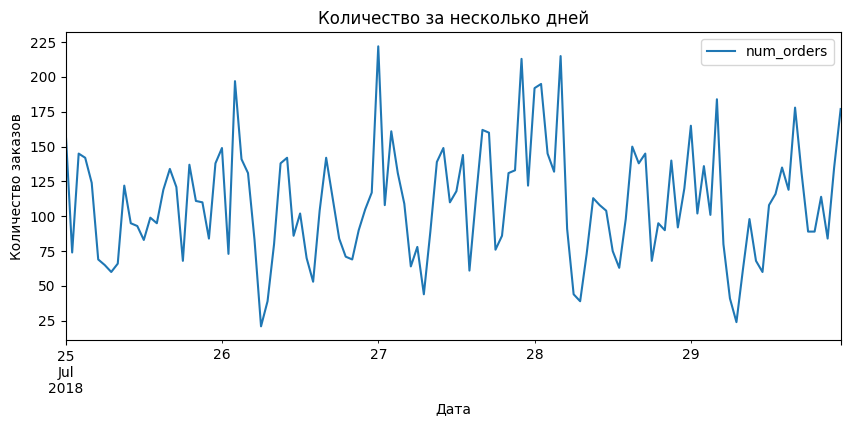

In [11]:
# посмотрим на несколько дней
few_days = df_resample['2018-07-25':'2018-07-29']
few_days.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Количество за несколько дней')
plt.show()

In [28]:
few_days_decomposed = seasonal_decompose(few_days)

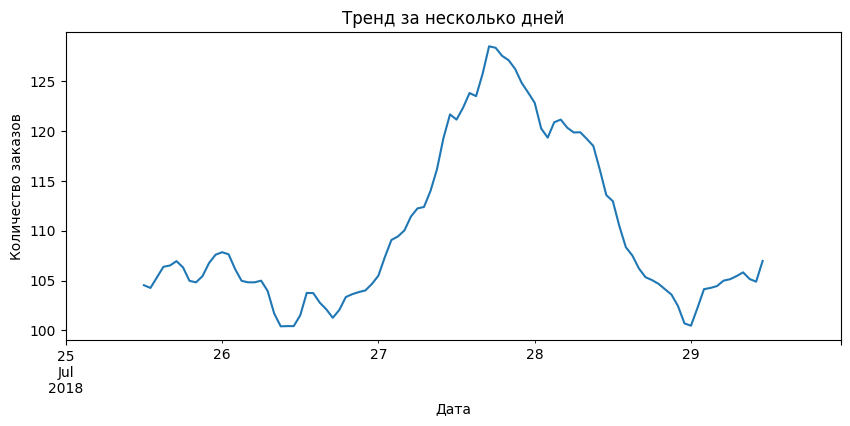

In [29]:
few_days_decomposed.trend.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Тренд за несколько дней')
plt.show()

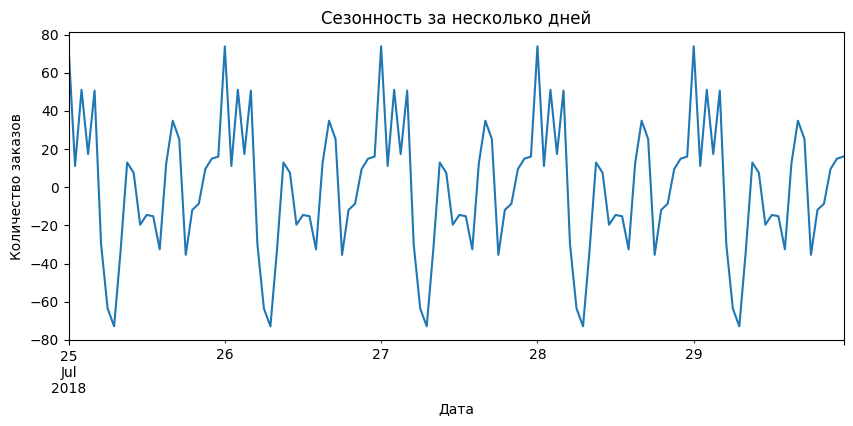

In [ ]:
few_days_decomposed.seasonal.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Сезонность за несколько дней')
plt.show()

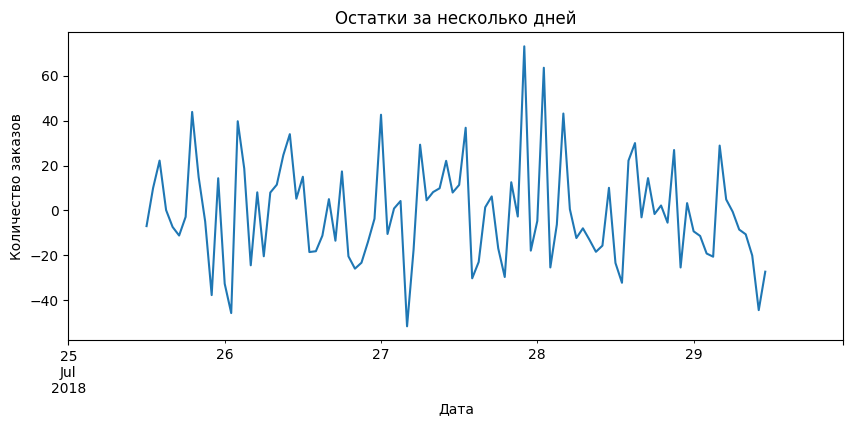

In [30]:
few_days_decomposed.resid.plot(figsize=(10,4))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Остатки за несколько дней')
plt.show()

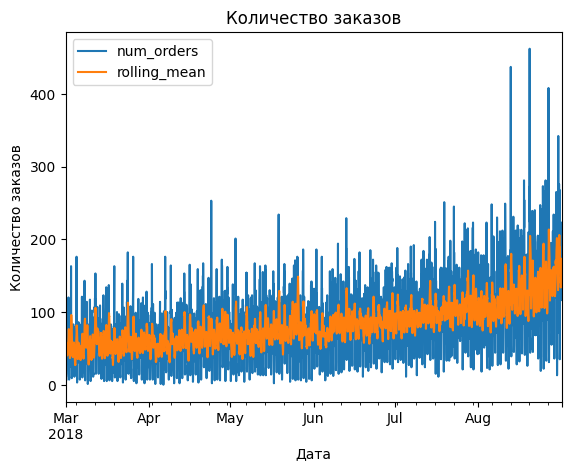

In [31]:
df_resample['rolling_mean'] = df_resample.shift().rolling(10).mean()
df_resample.plot()
plt.legend()
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Количество заказов')
plt.show()

Также видно, что есть суточная сезонность, поэтому нужно добавить некоторые столбцы: столбец с днём недели и часом.

In [32]:
def make_features(data, max_lag, rolling_mean_size):

    df_wf = data.copy()
    df_wf['day'] = df_wf.index.day
    df_wf['dayofweek'] = df_wf.index.dayofweek
    df_wf['hour'] = df_wf.index.hour

    for lag in range(1, max_lag + 1):
        df_wf['lag_{}'.format(lag)] = df_wf['num_orders'].shift(lag)

    df_wf['rolling_mean'] = df_wf['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df_wf.dropna()

In [33]:
df_resample.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


In [34]:
data = df_resample.copy()

In [35]:
new_df = make_features(data, 4, 6)
new_df.head()

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,
2018-03-01 06:00:00,12,65.833333,1,3,6,6.0,43.0,66.0,71.0
2018-03-01 07:00:00,15,47.166667,1,3,7,12.0,6.0,43.0,66.0
2018-03-01 08:00:00,34,35.500000,1,3,8,15.0,12.0,6.0,43.0
2018-03-01 09:00:00,69,29.333333,1,3,9,34.0,15.0,12.0,6.0
2018-03-01 10:00:00,64,29.833333,1,3,10,69.0,34.0,15.0,12.0


In [36]:
# 10% от всех данных
test_s = (new_df.shape[0] //5)

In [38]:
def ts_rmse(data, regressor, hyperparams):
    best_rmse = 1000
    for i in tqdm_notebook(range(1, 30)):
        for k in tqdm_notebook(range(40, 60)):
            data = df_resample.copy()
            make_features(data, i, k)

            tscv = TimeSeriesSplit(gap=0, n_splits=2, test_size=test_s)
            for train_index, test_index in tscv.split(data):
                train = data.iloc[train_index]
                test = data.iloc[test_index]

                train = train.dropna()
                test = test.dropna()

                X_train = train.drop('num_orders', axis=1)
                y_train = train['num_orders']

                X_test = test.drop('num_orders', axis=1)
                y_test = test['num_orders']

                model = GridSearchCV(regressor, hyperparams, cv=tscv,
                                scoring='neg_mean_squared_error', n_jobs=-1)
                model.fit(X_train, y_train)

                best_score = model.best_score_
                best_params = model.best_params_

    print('best_score: ', (- model.best_score_)**0.5)
    return X_test, y_test, X_train, y_train, best_params, (- model.best_score_)**0.5

## Обучение

### Линейная регрессия

In [39]:
%%time
hp_lr = [{}]
X_test_lr, y_test_lr, X_train_lr, y_train_lr, params_lr, rmse_lr = ts_rmse(data, regressor=LinearRegression(), hyperparams=hp_lr)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

best_score:  37.55977837169898
CPU times: user 21.1 s, sys: 740 ms, total: 21.8 s
Wall time: 38.7 s


### DecisionTreeRegressor

In [41]:
hp_dtr = hyperparams = [{"splitter":["best","random"],
            "max_depth" : [None] + [i for i in range(2, 7)],
           "min_samples_leaf":[1,2,3],
           "min_weight_fraction_leaf":[0.1,0.2],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20]
                        }]

In [42]:
%time
X_test_dtr, y_test_dtr, X_train_dtr, y_train_dtr, params_dtr, rmse_dtr = ts_rmse(data, regressor=DecisionTreeRegressor(random_state=12345), hyperparams=hp_dtr)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.54 µs


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

best_score:  37.951839615505584


### Регрессия LGBMRegressor

In [53]:
hp_lgbm = [{'learning_rate':[x for x in [0.06, 0.08, 0.1]],
            'max_depth': [i for i in range(2, 10)],
            'num_leaves': [10, 20, 30],
            'n_estimators': [200]
           }]

In [54]:
%%time
X_test_lgbm, y_test_lgbm, X_train_lgbm, y_train_lgbm, params_lgbm, rmse_lgbm = ts_rmse(data, regressor=LGBMRegressor(), hyperparams=hp_lgbm)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

best_score:  38.49320631411573
CPU times: user 5min 52s, sys: 11.2 s, total: 6min 3s
Wall time: 1h 17min 12s


### CatBoostRegressor

In [47]:
hp_cbr = [{'learning_rate':[x for x in [0.06, 0.08, 0.1]],
            'max_depth': [i for i in range(2, 7)],
            'n_estimators': [200]
          }]

In [48]:
%%time
X_test_cbr, y_test_cbr, X_train_cbr, y_train_cbr, params_cbr, rmse_cbr = ts_rmse(data, regressor=CatBoostRegressor(verbose=False), hyperparams=hp_cbr)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

best_score:  38.2276763690301
CPU times: user 3min 41s, sys: 23.3 s, total: 4min 4s
Wall time: 52min 56s


### Dummy Regressor

In [49]:
classificator = DummyRegressor()
classificator.fit(X_train_lr, y_train_lr)
test_predict = classificator.predict(X_test_lr)
rmse = mean_squared_error(test_predict, y_test_lr)**0.5
print('RMSE на тесте: ', rmse)

RMSE на тесте:  74.4248594975294


In [58]:
models_time = pd.DataFrame([
    ['LinearRegression', '38.7 s', 37.55977837169898],
    ['DecisionTreeRegressor', '34min 54s', 37.951839615505584],
    ['LGBMRegressor', '1h 17min 12s', rmse_lgbm],
    ['CatBoostRegressor','52min 56s', rmse_cbr],
    ['DummyRegressor','10.23 s', rmse]
],
    columns=['Модель', 'Время обучения', 'RMSE']
)
models_time

,Модель,Время обучения,RMSE
0,LinearRegression,38.7 s,37.559778
1,DecisionTreeRegressor,34min 54s,37.951840
2,LGBMRegressor,1h 17min 12s,38.493206
3,CatBoostRegressor,52min 56s,38.227676
4,DummyRegressor,10.23 s,74.424859


Лучший результат показала модель линейной регрессии (37.559778). Стоит отметить, что все полученные значения метрики RMSE лучше, чем у Dummy модели (74.425896). Тестировать мы будем модель линейной регрессии.

## Тестирование

### Регрессия LGBMRegressor

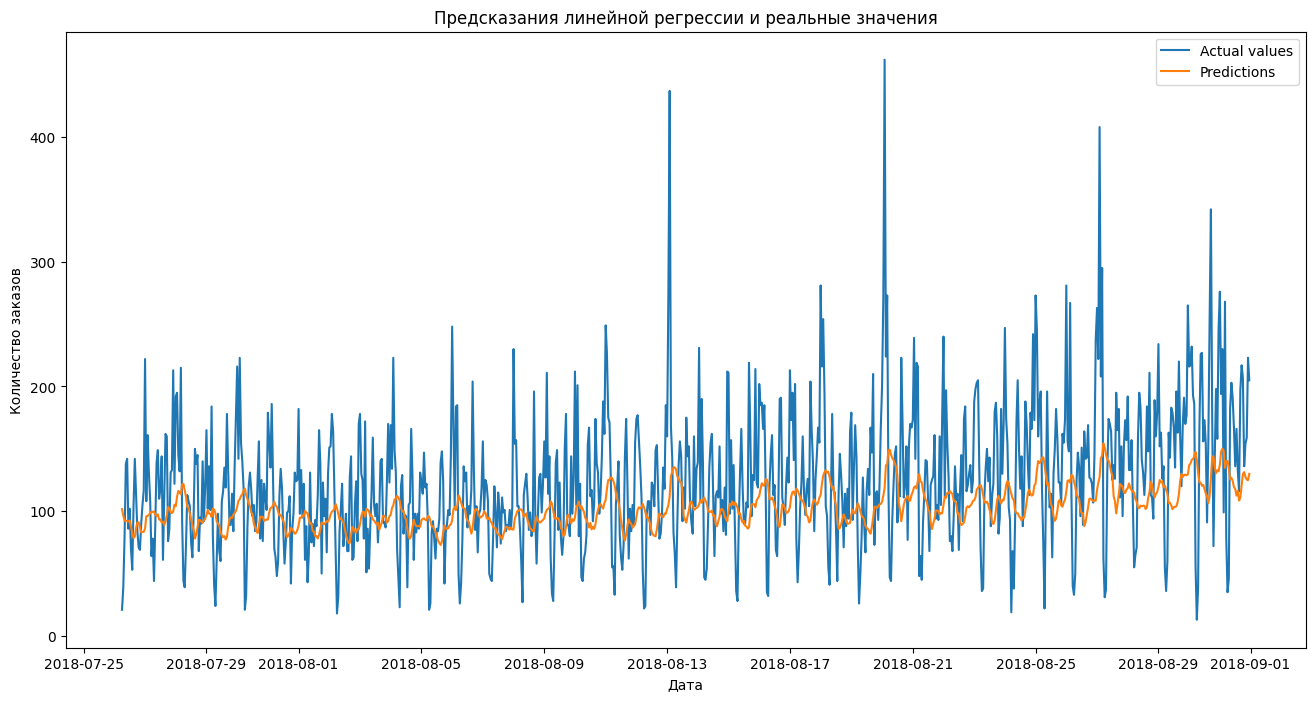

RMSE на тестовой выборке:  57.80179978874456


In [59]:
classificator = LinearRegression()
classificator.set_params(**params_lr)
classificator.fit(X_train_lr, y_train_lr)
test_predict = classificator.predict(X_test_lr)
rmse_lr = mean_squared_error(test_predict, y_test_lr)**0.5

plt.figure(figsize=(16,8))
plt.plot(y_test_lr.index,
         y_test_lr, label='Actual values')
plt.plot(y_test_lr.index,
         test_predict, label='Predictions'
        )
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Предсказания линейной регрессии и реальные значения')
plt.legend()
plt.show()
print('RMSE на тестовой выборке: ', rmse_lr)

Мы проверили нашу лучшую модель, качество LGBMRegressor на тестовых данных стало несколько хуже (55.08).

## Вывод

В ходе нашей работы был проведён анализ временного ряда. Было проведено ресемплирование наших данных. Рассмотрена сезонность, по критерию Дики-Фуллера наш временной ряд стационарен (5%), для уровня значимости в 1% наш ряд не стационарен.

Далее были обучены 4 различные модели (линейная регрессия, DecisionTreeRegressor, LGBMRegressor и CatBoost), были подобраны наилучшие гиперпараметры. Лучшее качество показала линейная регрессия ($rmse = 57.80$), худшее качество - у lgbm ($rmse  = 	38.49$).